<a href="https://colab.research.google.com/github/izik-adio/Predictive-Modelling-for-COVID-19/blob/main/eda_to_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
This notebook presents a data science capstone project focused on **predictive modeling for COVID-19** in public health. The goal is gaining actionable insights from historical COVID-19 data. Key tasks include:  

1. **Data Preparation**: Cleaning, transforming, and engineering features from the CORD-19 dataset to ensure high-quality inputs for analysis.  
2. **Exploratory Data Analysis (EDA)**: Identifying trends, correlations, and key factors influencing COVID-19 spread and severity through visualizations.  
3. **Predictive Modeling**: Building and evaluating time-series and classification models to forecast trends and outcomes.  
4. **Visualization & Reporting**: Delivering insights via clear visualizations and a structured report to support decision-making for public health policies and resource allocation.  

This project is a comprehensive effort to leverage data science for improving public health responses during the COVID-19 pandemic.

### The dataset used is gotten from [Kaggle](https://www.kaggle.com/datasets/imdevskp/corona-virus-report), below is a brief overview of what is contained in each csv file

* full_grouped.csv - Day to day country wise no. of cases (Has County/State/Province level data)
* covid_19_clean_complete.csv - Day to day country wise no. of cases (Doesn't have County/State/Province level data)
* country_wise_latest.csv - Latest country level no. of cases
* day_wise.csv - Day wise no. of cases (Doesn't have country level data)
* usa_county_wise.csv - Day to day county level no. of cases
* worldometer_data.csv - Latest data from https://www.worldometers.info/


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
data_url = "https://raw.githubusercontent.com/izik-adio/Predictive-Modelling-for-COVID-19/refs/heads/main/data/"
files = ["country_wise_latest.csv", "covid_19_clean_complete.csv", "day_wise.csv", "full_grouped.csv", "usa_county_wise.csv", "worldometer_data.csv"]

country_wise_latest = pd.read_csv(data_url + files[0])
covid_19_clean_complete = pd.read_csv(data_url + files[1])
day_wise = pd.read_csv(data_url + files[2])
full_grouped = pd.read_csv(data_url + files[3])
usa_country_wise = pd.read_csv(data_url + files[4])
worldometer_data = pd.read_csv(data_url + files[5])

#Data Cleaning and preprocessing

In [55]:
# Handle inconsistencies in column names:
country_wise_latest = country_wise_latest.rename(columns={'Country/Region': 'Country_Region'})
worldometer_data = worldometer_data.rename(columns={'Country/Region': 'Country_Region'})
full_grouped = full_grouped.rename(columns={'Country/Region': 'Country_Region'})
covid_19_clean_complete = covid_19_clean_complete.rename(columns={'Country/Region': 'Country_Region'})

In [56]:
# Convert 'Date' column to datetime if needed.  Adjust format if necessary
covid_19_clean_complete['Date'] = pd.to_datetime(covid_19_clean_complete['Date'])
full_grouped['Date'] = pd.to_datetime(full_grouped['Date'])
day_wise['Date'] = pd.to_datetime(day_wise['Date'])

In [57]:
# Merging the datasets
# Prioritize covid_19_clean_complete, which has daily data

merged_data = covid_19_clean_complete.copy()

# Merge with full_grouped (adds additional daily metrics)
merged_data = pd.merge(merged_data, full_grouped, on=['Country_Region', 'Date', 'Confirmed', 'Deaths', 'Recovered','Active','WHO Region'],how='left')

#Merge with country_wise_latest (adds latest overall metrics)
merged_data = pd.merge(merged_data, country_wise_latest, on=['Country_Region'], how='left', suffixes=('_daily','_latest'))

#Merge with worldometer_data(population and other metrics)
merged_data = pd.merge(merged_data, worldometer_data, on=['Country_Region'], how='left', suffixes=('_covid','_worldometer'))

In [58]:
merged_data.duplicated().sum()

0

In [59]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Province/State          14664 non-null  object        
 1   Country_Region          49068 non-null  object        
 2   Lat                     49068 non-null  float64       
 3   Long                    49068 non-null  float64       
 4   Date                    49068 non-null  datetime64[ns]
 5   Confirmed_daily         49068 non-null  int64         
 6   Deaths_daily            49068 non-null  int64         
 7   Recovered_daily         49068 non-null  int64         
 8   Active_daily            49068 non-null  int64         
 9   WHO Region_daily        49068 non-null  object        
 10  New cases_daily         34353 non-null  float64       
 11  New deaths_daily        34353 non-null  float64       
 12  New recovered_daily     34353 non-null  float6

In [60]:
merged_data['CFR'] = (merged_data['Deaths_latest'] / merged_data['Confirmed_latest']) * 100

In [61]:
merged_data[[ 'WHO Region_daily','WHO Region_latest', 'WHO Region']].head()

,WHO Region_daily,WHO Region_latest,WHO Region
0,Eastern Mediterranean,Eastern Mediterranean,EasternMediterranean
1,Europe,Europe,Europe
2,Africa,Africa,Africa
3,Europe,Europe,Europe
4,Africa,Africa,Africa


In [62]:
# drop redundant columns
columns_to_drop = ['Province/State', 'Lat', 'Long', 'WHO Region_latest', 'WHO Region','New cases_daily', 'New deaths_daily', 'New recovered_daily', 'Confirmed_daily', 'Deaths_daily', 'Recovered_daily','Active_daily','Continent','Population','TotalCases','TotalDeaths','ActiveCases','Serious,Critical','Tot Cases/1M pop','Deaths/1M pop','TotalTests','Tests/1M pop', '1 week % increase', 'NewCases', "NewDeaths", "NewRecovered"]

merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')

print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Country_Region          49068 non-null  object        
 1   Date                    49068 non-null  datetime64[ns]
 2   WHO Region_daily        49068 non-null  object        
 3   Confirmed_latest        49068 non-null  int64         
 4   Deaths_latest           49068 non-null  int64         
 5   Recovered_latest        49068 non-null  int64         
 6   Active_latest           49068 non-null  int64         
 7   New cases_latest        49068 non-null  int64         
 8   New deaths_latest       49068 non-null  int64         
 9   New recovered_latest    49068 non-null  int64         
 10  Deaths / 100 Cases      49068 non-null  float64       
 11  Recovered / 100 Cases   49068 non-null  float64       
 12  Deaths / 100 Recovered  49068 non-null  float6

In [63]:
# Rename columns
new_column_names = {
    'Country_Region': 'country',
    'Date': 'date',
    'WHO Region_daily': 'who_region',
    'Confirmed_latest': 'confirmed',
    'Deaths_latest': 'deaths',
    'Recovered_latest': 'recovered',
    'Active_latest': 'active',
    'New cases_latest': 'new_cases',
    'New deaths_latest': 'new_deaths',
    'New recovered_latest': 'new_recovered',
    'Deaths / 100 Cases': 'death_rate_cases',
    'Recovered / 100 Cases': 'recovery_rate_cases',
    'Deaths / 100 Recovered': 'death_rate_recovered',
    'Confirmed last week': 'prev_week_confirmed',
    '1 week change': 'weekly_change',
    'TotalRecovered': 'total_recovered',
    'CFR': 'case_fatality_rate'
}
df = merged_data.rename(columns=new_column_names)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   country               49068 non-null  object        
 1   date                  49068 non-null  datetime64[ns]
 2   who_region            49068 non-null  object        
 3   confirmed             49068 non-null  int64         
 4   deaths                49068 non-null  int64         
 5   recovered             49068 non-null  int64         
 6   active                49068 non-null  int64         
 7   new_cases             49068 non-null  int64         
 8   new_deaths            49068 non-null  int64         
 9   new_recovered         49068 non-null  int64         
 10  death_rate_cases      49068 non-null  float64       
 11  recovery_rate_cases   49068 non-null  float64       
 12  death_rate_recovered  49068 non-null  float64       
 13  prev_week_confir

In [64]:
# add few columns for better EDA and MODELING
df['month'] = df['date'].dt.month

df['death_rate'] = df['deaths'] / df['confirmed']
df['recovery_rate'] = df['recovered'] / df['confirmed']
df['active_proportion'] = df['active'] / df['confirmed']

In [65]:
#Save the transformed dataframe.
df.to_csv('merged_covid_data.csv', index=False)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   country               49068 non-null  object        
 1   date                  49068 non-null  datetime64[ns]
 2   who_region            49068 non-null  object        
 3   confirmed             49068 non-null  int64         
 4   deaths                49068 non-null  int64         
 5   recovered             49068 non-null  int64         
 6   active                49068 non-null  int64         
 7   new_cases             49068 non-null  int64         
 8   new_deaths            49068 non-null  int64         
 9   new_recovered         49068 non-null  int64         
 10  death_rate_cases      49068 non-null  float64       
 11  recovery_rate_cases   49068 non-null  float64       
 12  death_rate_recovered  49068 non-null  float64       
 13  prev_week_confir

In [67]:
mean_value = df['total_recovered'].mean()
df['total_recovered'] = df['total_recovered'].fillna(mean_value)
df.head()

,country,date,who_region,confirmed,deaths,recovered,active,new_cases,new_deaths,new_recovered,...,recovery_rate_cases,death_rate_recovered,prev_week_confirmed,weekly_change,total_recovered,case_fatality_rate,month,death_rate,recovery_rate,active_proportion
0,Afghanistan,2020-01-22,Eastern Mediterranean,36263,1269,25198,9796,106,10,18,...,69.49,5.04,35526,737,25840.0,3.499435,1,0.034994,0.694868,0.270138
1,Albania,2020-01-22,Europe,4880,144,2745,1991,117,6,63,...,56.25,5.25,4171,709,3155.0,2.950820,1,0.029508,0.562500,0.407992
2,Algeria,2020-01-22,Africa,27973,1163,18837,7973,616,8,749,...,67.34,6.17,23691,4282,23238.0,4.157581,1,0.041576,0.673399,0.285025
3,Andorra,2020-01-22,Europe,907,52,803,52,10,0,0,...,88.53,6.48,884,23,828.0,5.733186,1,0.057332,0.885336,0.057332
4,Angola,2020-01-22,Africa,950,41,242,667,18,1,0,...,25.47,16.94,749,201,520.0,4.315789,1,0.043158,0.254737,0.702105


#Exploratory Data Analysis

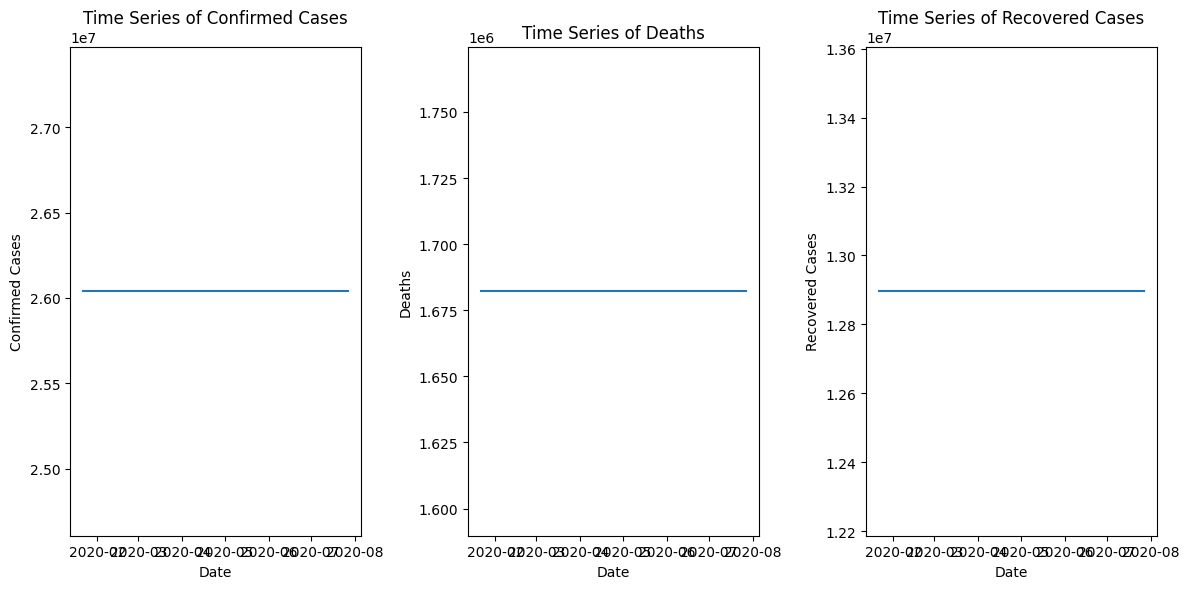

In [68]:
# Group data by date and sum the relevant variables
grouped_data = df.groupby('date')[['confirmed', 'deaths', 'recovered']].sum()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # 3 rows, 1 column of subplots

# Plot each variable on a separate subplot with better labeling
axes[0].plot(grouped_data['confirmed'])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Confirmed Cases')
axes[0].set_title('Time Series of Confirmed Cases')

axes[1].plot(grouped_data['deaths'])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Deaths')
axes[1].set_title('Time Series of Deaths')

axes[2].plot(grouped_data['recovered'])
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Recovered Cases')
axes[2].set_title('Time Series of Recovered Cases')

plt.tight_layout()  # Adjusts subplot parameters for a tight layout
plt.show()

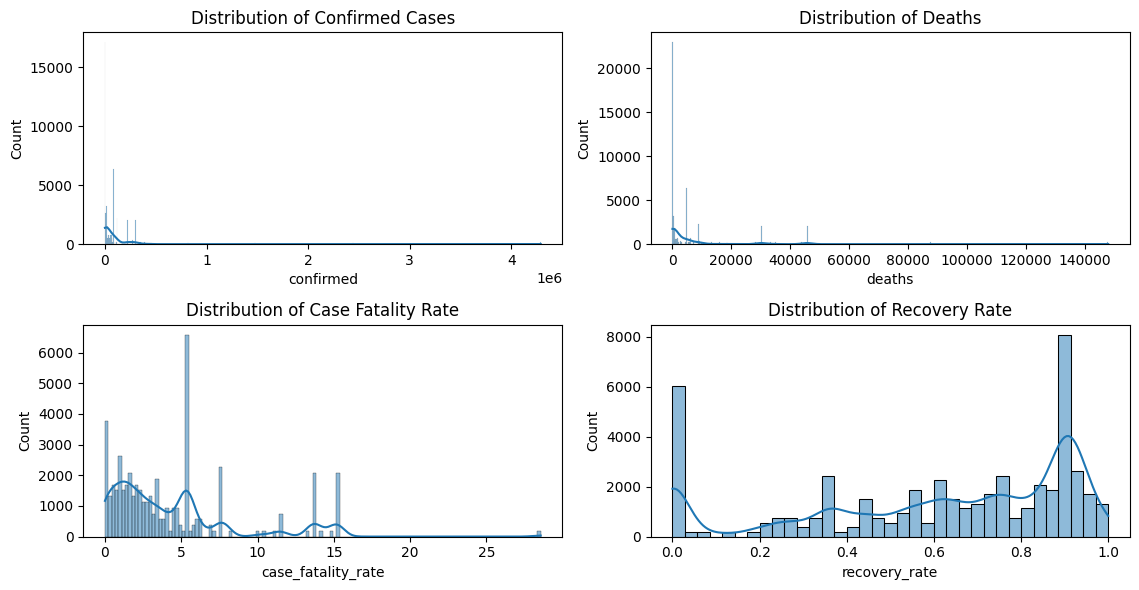

In [69]:
# Distribution of Key Variables:
plt.figure(figsize=(11.5, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['confirmed'], kde=True)
plt.title('Distribution of Confirmed Cases')

plt.subplot(2, 2, 2)
sns.histplot(df['deaths'], kde=True)
plt.title('Distribution of Deaths')

plt.subplot(2, 2, 3)
sns.histplot(df['case_fatality_rate'], kde=True)
plt.title('Distribution of Case Fatality Rate')

plt.subplot(2, 2, 4)
sns.histplot(df['recovery_rate'], kde=True)
plt.title('Distribution of Recovery Rate')

plt.tight_layout()
plt.show()

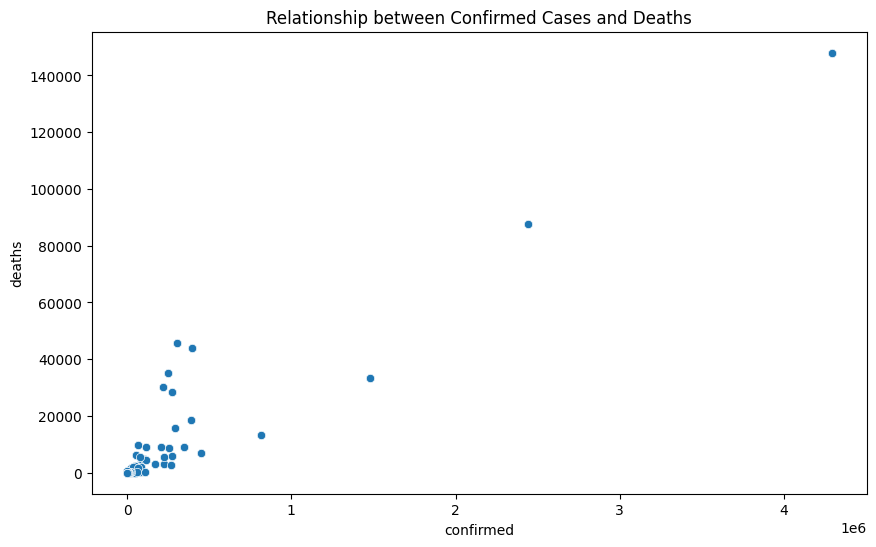

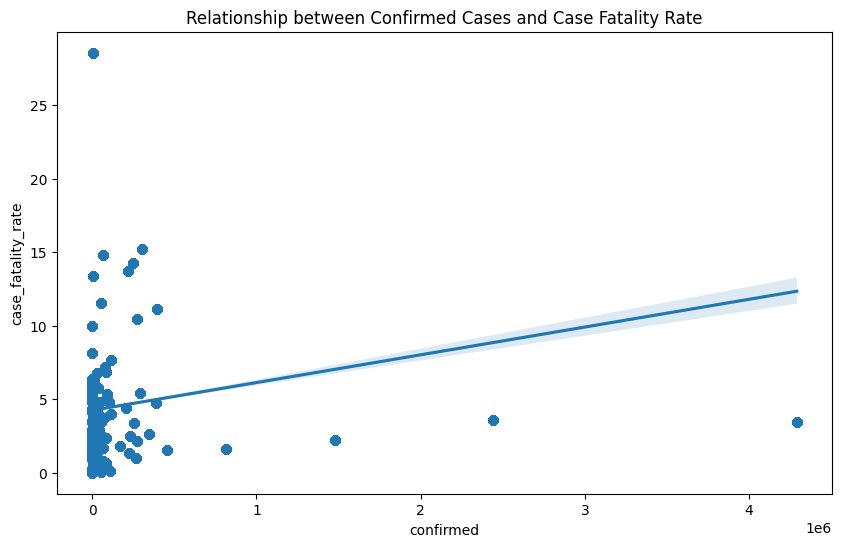

In [70]:
# Relationship between Variables:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='confirmed', y='deaths', data=df)
plt.title('Relationship between Confirmed Cases and Deaths')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='confirmed', y='case_fatality_rate', data=df)
plt.title('Relationship between Confirmed Cases and Case Fatality Rate')
plt.show()

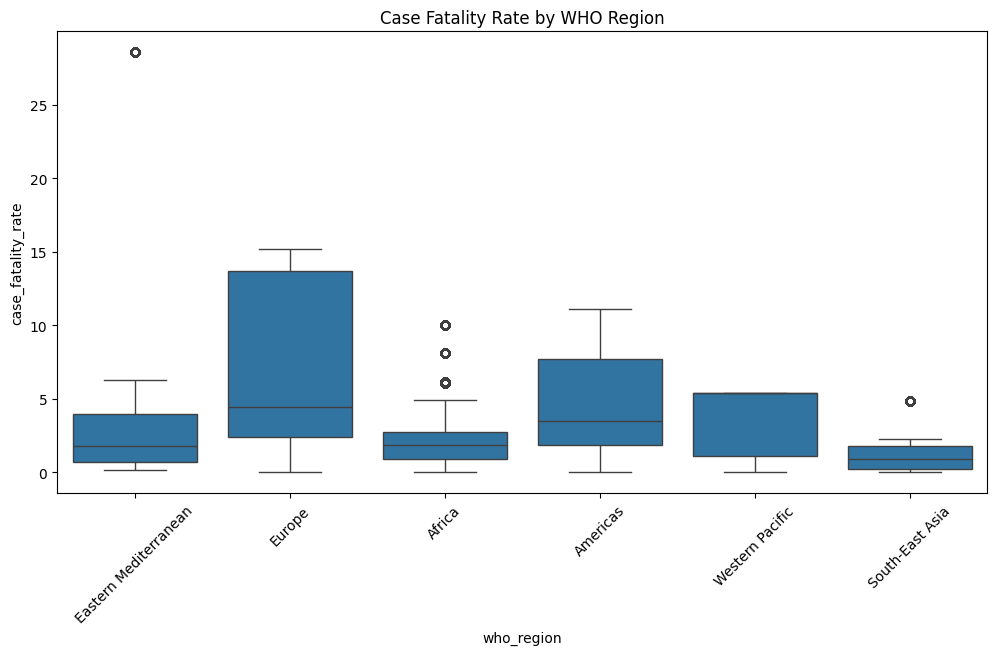

In [71]:
# Analysis by WHO Region:

plt.figure(figsize=(12, 6))
sns.boxplot(x='who_region', y='case_fatality_rate', data=df)
plt.title('Case Fatality Rate by WHO Region')
plt.xticks(rotation=45)
plt.show()

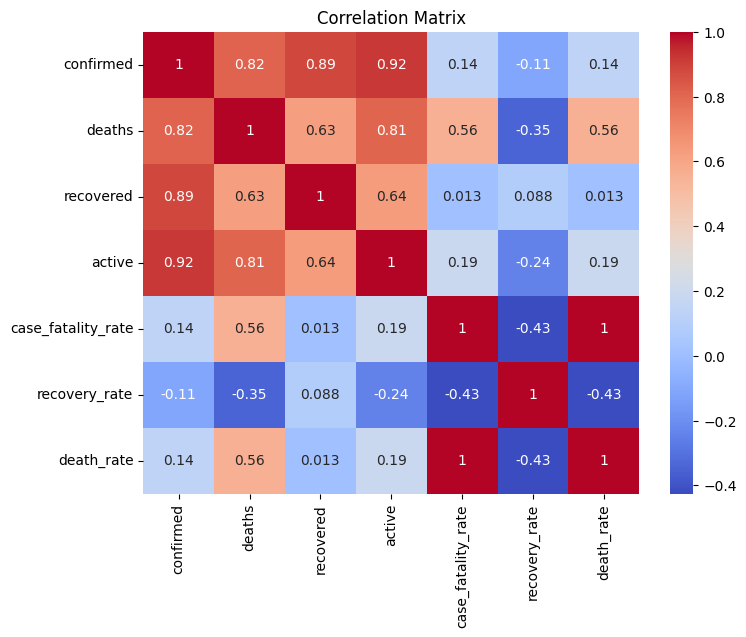

In [72]:
# Correlation Matrix:
corr_matrix = df[['confirmed', 'deaths', 'recovered', 'active', 'case_fatality_rate', 'recovery_rate', 'death_rate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [74]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_cols = ['confirmed', 'deaths', 'recovered',
       'active', 'new_cases', 'new_deaths', 'new_recovered',
       'death_rate_cases', 'recovery_rate_cases', 'death_rate_recovered',
       'prev_week_confirmed', 'weekly_change', 'total_recovered',
       'case_fatality_rate', 'month', 'death_rate', 'recovery_rate',
       'active_proportion']
categorical_cols = ['country', 'who_region']
df.replace([np.inf, -np.inf], np.nan, inplace=True)


scaler_standard = StandardScaler()
df[numerical_cols] = scaler_standard.fit_transform(df[numerical_cols])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
df.head()

,date,confirmed,deaths,recovered,active,new_cases,new_deaths,new_recovered,death_rate_cases,recovery_rate_cases,...,country_Western Sahara,country_Yemen,country_Zambia,country_Zimbabwe,who_region_Africa,who_region_Americas,who_region_Eastern Mediterranean,who_region_Europe,who_region_South-East Asia,who_region_Western Pacific
0,2020-01-22,-0.193965,-0.340677,-0.149625,-0.182938,-0.199074,-0.125624,-0.186821,-0.213177,0.271451,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2020-01-22,-0.289814,-0.414718,-0.288365,-0.224789,-0.196803,-0.164903,-0.174202,-0.339037,-0.151973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2020-01-22,-0.219284,-0.347653,-0.188931,-0.192713,-0.093785,-0.145263,0.018164,-0.062145,0.202693,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-22,-0.301949,-0.420773,-0.300364,-0.235186,-0.218893,-0.223821,-0.191868,0.297127,0.880364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2020-01-22,-0.301817,-0.421497,-0.303831,-0.231888,-0.217242,-0.214001,-0.191868,-0.025531,-1.136339,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X = df.drop(columns=['target'])
y = df['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' handles multiclass
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
